In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random

#Size of our input images
SIZE = 128

## Load Data

In [12]:
batch_size = 64
datagen = ImageDataGenerator(rescale=1./255)

In [18]:

#train_data = os.listdir('cell_images/Uninfected_train/')
train_image = 'cell_images/Uninfected_train/'
train_generator = datagen.flow_from_directory( train_image, target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input') # Class "input" means, we not doing any classification but we are concern about the image itself. "binary" or "categoritical" could be use if we are doig classification



Found 12827 images belonging to 1 classes.


In [19]:
test_generator = datagen.flow_from_directory('cell_images/Uninfected_test/',target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input'
    )

Found 952 images belonging to 1 classes.


In [20]:
#parasitized_data = os.listdir('../Desktop/My_GitHub/image_anomaly_detection_using_DAEs/cell_images/Parasitized/')
anomaly_generator = datagen.flow_from_directory(
    'cell_images/Parasitized',
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input'
    )

Found 13779 images belonging to 1 classes.


### Let's define the denoising autoencoder. We will make the bottleneck layer size as small as possible to make it easy for density calculations and also picking appropriate thresholds, which will serve as a benchmark for your detection.

## Encoder

In [21]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 3)))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))


## Decoder

In [22]:
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 64, 64, 32)        18464     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 32, 32, 16)        4624      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 16, 16, 16)      

## Fit the model

In [23]:
 
history = model.fit(
        train_generator,
        steps_per_epoch= 500 // batch_size,
        epochs=600,
        validation_data=test_generator,
        validation_steps=75 // batch_size,
        shuffle = True)

Epoch 1/600
7/7 [==============================] - 5s 684ms/step - loss: 0.0871 - mse: 0.0871 - val_loss: 0.0758 - val_mse: 0.0758
Epoch 2/600
7/7 [==============================] - 5s 717ms/step - loss: 0.0638 - mse: 0.0638 - val_loss: 0.0400 - val_mse: 0.0400
Epoch 3/600
7/7 [==============================] - 5s 719ms/step - loss: 0.0298 - mse: 0.0298 - val_loss: 0.0163 - val_mse: 0.0163
Epoch 4/600
7/7 [==============================] - 5s 742ms/step - loss: 0.0174 - mse: 0.0174 - val_loss: 0.0162 - val_mse: 0.0162
Epoch 5/600
7/7 [==============================] - 5s 742ms/step - loss: 0.0162 - mse: 0.0162 - val_loss: 0.0143 - val_mse: 0.0143
Epoch 6/600
7/7 [==============================] - 5s 706ms/step - loss: 0.0144 - mse: 0.0144 - val_loss: 0.0146 - val_mse: 0.0146
Epoch 7/600
7/7 [==============================] - 5s 719ms/step - loss: 0.0131 - mse: 0.0131 - val_loss: 0.0106 - val_mse: 0.0106
Epoch 8/600
7/7 [==============================] - 5s 730ms/step - loss: 0.0119 - m

## plot the training and validation accuracy and loss at each epoch

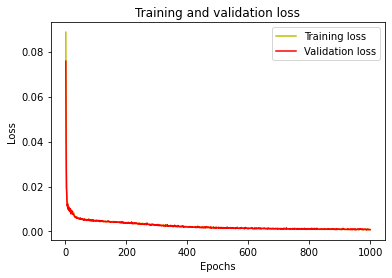

In [14]:

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Get all batches generated by the datagen and pick a batch for prediction Just to test the trained model. 

In [24]:
data_batch = []  #Capture all training batches as a numpy array
img_num = 0
while img_num <= train_generator.batch_index:   #gets each generated batch of size batch_size
    data = train_generator.next() # ".next" generates batches for all images
    data_batch.append(data[0])
    img_num = img_num + 1

predicted = model.predict(data_batch[0])  #Predict on the first batch of images


2/2 [==============================] - 0s 148ms/step


### Sanity check: Let's view few images and their corresponding reconstructions counterparts

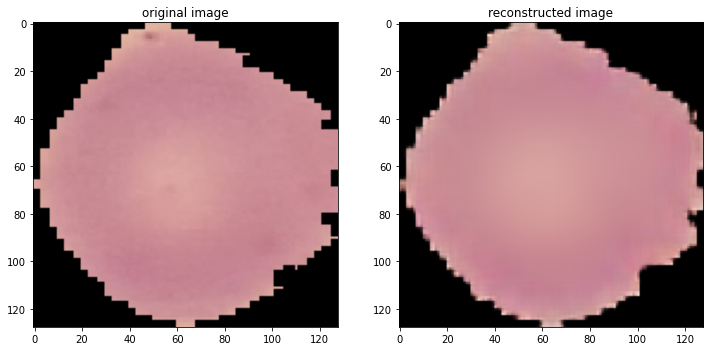

In [28]:
image_number = random.randint(0, predicted.shape[0])
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(data_batch[0][image_number])
plt.title("original image")
plt.subplot(122)
plt.imshow(predicted[image_number])
plt.title("reconstructed image")
plt.show()

### Let's evaluate the reconstruction error between our test data (Uninfected images) and the anomaly images(Infected images)

It is important to note that when we do "model.evaluate_generatetor", it is going to return two outputs based on what you defind in your model compilation. In our case, we defined "loss" and "metrics"

In [29]:
validation_error = model.evaluate_generator(test_generator) # checking for reconstructed error for normal images
anomaly_error = model.evaluate_generator(anomaly_generator)# checking for reconstructed error for affected images

/tmp/ipykernel_5531/3145626502.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  validation_error = model.evaluate_generator(test_generator)
/tmp/ipykernel_5531/3145626502.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  anomaly_error = model.evaluate_generator(anomaly_generator)


In [30]:
print("Recon. error for the validation (normal) data is: ", validation_error)
print("Recon. error for the anomaly data is: ", anomaly_error)

Recon. error for the validation (normal) data is:  [0.0015151164261624217, 0.0015151164261624217]
Recon. error for the anomaly data is:  [0.002154456451535225, 0.002154456451535225]


### Let us extract (or build) the encoder network, with trained weights from the model we trained above. This is used to get the compressed output (latent space) of the input image. The compressed output is then used to calculate the KDE.

#### However, to calculate the kernel density error, we have to take the model up to the end of the encoder part where we have the bottleneck.

#### Here we build a new encoder network and populates it with the weights from the trained network above.



#### We are not going to train this model because it alread have weigts, we will use it as our feature or latent vector space generator

In [31]:
encoder_model = Sequential()
encoder_model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 3), weights=model.layers[0].get_weights()) )
encoder_model.add(MaxPooling2D((2, 2), padding='same'))
encoder_model.add(Conv2D(32, (3, 3), activation='relu', padding='same', weights=model.layers[2].get_weights()))
encoder_model.add(MaxPooling2D((2, 2), padding='same'))
encoder_model.add(Conv2D(16, (3, 3), activation='relu', padding='same', weights=model.layers[4].get_weights()))
encoder_model.add(MaxPooling2D((2, 2), padding='same'))
encoder_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 64, 64, 32)        18464     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 32, 32, 16)        4624      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 16, 16, 16)      

### Let generate our latent space vectors by get encoded output of input images, using the training data. This is equal to the Latent space vector. We will use this vector to claculate the kernal density estimation.

In [34]:
from sklearn.neighbors import KernelDensity
encoded_images = encoder_model.predict_generator(train_generator) # This is not a latent vector yet it is a tensor because we haven't flatten it yet.

/tmp/ipykernel_5531/1649889420.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  encoded_images = encoder_model.predict_generator(train_generator) # This is not a latent vector yet it is a tensor because we haven't flatten it yet.


In [ ]:
### # Flatten the encoder output because KDE from sklearn takes 1D vectors as input. Flatteening will convert the 2D image to 1D.

In [41]:
encoder_output_shape = encoder_model.output_shape #Here, we have 16x16x16
out_vector_shape = encoder_output_shape[1]*encoder_output_shape[2]*encoder_output_shape[3]


In [40]:
print(out_vector_shape)

4096


### Let reshape our encoded image and convert it into a vector.

In [43]:
encoded_images_vector = [np.reshape(encoded_img, (out_vector_shape)) for encoded_img in encoded_images]

### Fit KDE to the image latent data or encoded image vector.

In [46]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(encoded_images_vector)

### Calculate density and reconstruction error to find their means values for good and anomaly images. We use these mean and sigma to set thresholds.


#### To set a thgreshold on our density and our reconstruction error, we need to know what these values are on our Uninfected image. To do that, we defind a function called "calc_density_and_recon_error"


In [50]:
 
def calc_density_and_recon_error(batch_images):
    
    density_list=[]
    recon_error_list=[]
    for im in range(0, batch_images.shape[0]-1):
        
        img  = batch_images[im]
        img = img[np.newaxis, :,:,:] # Load each image
        encoded_img = encoder_model.predict([[img]]) # Create a compressed version of the image using the encoder
        encoded_img = [np.reshape(img, (out_vector_shape)) for img in encoded_img] # Flatten the compressed image
        density = kde.score_samples(encoded_img)[0] # get a density score for the new image
        reconstruction = model.predict([[img]]) # Recontruction 
        reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0] #Recontruction error can be get from here
        density_list.append(density)
        recon_error_list.append(reconstruction_error)
        
    average_density = np.mean(np.array(density_list))  
    stdev_density = np.std(np.array(density_list)) 
    
    average_recon_error = np.mean(np.array(recon_error_list))  #This gets the mean of density and reconstruction error for both normal and infected images.
    stdev_recon_error = np.std(np.array(recon_error_list)) # #This gets the std of density and reconstruction error for both normal and infected images.
    
    return average_density, stdev_density, average_recon_error, stdev_recon_error


#For this let us 
train_batch = train_generator.next()[0] #  generate a batch of the normal images.
anomaly_batch = anomaly_generator.next()[0] #  generate a batch of the infected images.

uninfected_values = calc_density_and_recon_error(train_batch) # calc_density_and_recon_error for normal images
anomaly_values = calc_density_and_recon_error(anomaly_batch) # calc_density_and_recon_error for infected images



1/1 [==============================] - 0s 29ms/step - loss: 0.0026 - mse: 0.0026


### Now,Let feed in unknown random input images to check if there is anomaly or not. This will demaonstrate the robustness of our autoencoder.

In [51]:
def check_anomaly(img_path):
    density_threshold = 2500 #Set this value based on the above exercise
    reconstruction_error_threshold = 0.004 # Set this value based on the above exercise
    img  = Image.open(img_path)
    img = np.array(img.resize((128,128), Image.ANTIALIAS))
    plt.imshow(img)
    img = img / 255.
    img = img[np.newaxis, :,:,:]
    encoded_img = encoder_model.predict([[img]]) 
    encoded_img = [np.reshape(img, (out_vector_shape)) for img in encoded_img] 
    density = kde.score_samples(encoded_img)[0] 

    reconstruction = model.predict([[img]])
    reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]

    if density < density_threshold or reconstruction_error > reconstruction_error_threshold:
        print("The image is an anomaly")
        
    else:
        print("The image is NOT an anomaly")
        

In [ ]:
### Let's load a couple of test images and verify whether they are reported as anomalies or not.

1/1 [==============================] - 0s 31ms/step


/tmp/ipykernel_5531/1986561385.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step - loss: 0.0047 - mse: 0.0047
The image is an anomaly
1/1 [==============================] - 0s 19ms/step


/tmp/ipykernel_5531/1986561385.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0038 - mse: 0.0038
The image is NOT an anomaly


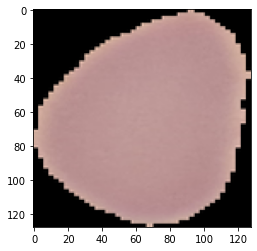

In [59]:
import glob
para_file_paths = glob.glob('cell_images/Parasitized/image_par/*') # take random images from the infected folder
uninfected_file_paths = glob.glob('cell_images/Uninfected_train/image/*') # take random images from the uninfected folder

#Anomaly image verification
num=random.randint(0,len(para_file_paths)-1)
check_anomaly(para_file_paths[num])

#Good/normal image verification
num=random.randint(0,len(para_file_paths)-1)
check_anomaly(uninfected_file_paths[num])